##  Lab - Multivariate Anomaly Detection

In this lab we will cover two methods useful for multivariate anomaly detection: 
Principal Component Analysis and Local Outlier Factor (which can also be used with bivariate data).

### Outlier Detection Using Principal Component Analysis

PCA, a linear model in Aggarwal's classification scheme, is a statistical procedure that uses a 
transformation to convert a set of observations of possibly correlated variables into a set of
values of linearly uncorrelated variables called principal components. 
The number of principal components is less than or equal to the number of original variables. 
This transformation is defined in such a way that the first principal component has the largest 
possible variance (that is, accounts for as much of the variability in the data as possible), 
and each succeeding component in turn has the highest variance possible under the constraint 
that it is orthogonal to the preceding components. 
The resulting vectors are an uncorrelated orthogonal basis set.

Using PCA we can map our dataset with n-dimension (possibly correlated variables) 
to a k-dimensional sub-space of k uncorrelated components (k<=n).

Below are steps for detecting anomalies using PCA:

First we map the data set from its original n-dimensional space to a k-dimensional subspace using PCA.

- Calculate the centroid of data points (μ)
- Calculate the variance of each component (λ)
- Calculate the score of each data point using below formula:

![PCA_formula.png MISSING](../images/PCA_formula.png)

- Finally, use extreme value analysis methods to find data points with extreme scores

You don't have to worry about applying above formula to calculate scores. 
PCA is already implemented. 
You just have to call the method to find the scores.

#### First we load the data and do some data prep.

In [1]:
library(psych)

In [2]:
# First we load the diamonds dataset
library(ggplot2)
data(diamonds)


Attaching package: ‘ggplot2’

The following objects are masked from ‘package:psych’:

    %+%, alpha



In [3]:
head(diamonds)
tail(diamonds)

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48


carat,cut,color,clarity,depth,table,price,x,y,z
0.72,Premium,D,SI1,62.7,59,2757,5.69,5.73,3.58
0.72,Ideal,D,SI1,60.8,57,2757,5.75,5.76,3.50
0.72,Good,D,SI1,63.1,55,2757,5.69,5.75,3.61
0.70,Very Good,D,SI1,62.8,60,2757,5.66,5.68,3.56
0.86,Premium,H,SI2,61.0,58,2757,6.15,6.12,3.74
0.75,Ideal,D,SI2,62.2,55,2757,5.83,5.87,3.64


In [4]:
# Run the cell to know more about the data
help(diamonds)

First we need to convert categorical variables to dummy variables since PCA doesn't work with character type factors. 
In the cell below we illustrate how dummy coding works. You may also read more in this reference: 

**Reference:** [Dummy coding the data](http://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/)


In [5]:
# Generate example dataframe with character column
example <- as.data.frame(c("A", "A", "B", "F", "C", "G", "C", "D", "E", "F"))
names(example) <- "strcol"
print(example)
# For every unique value in the string column, create a new 1/0 column
# This is what Factors do "under-the-hood" automatically when passed to function requiring numeric data
for(level in unique(example$strcol)){
  example[paste("dummy", level, sep = "_")] <- ifelse(example$strcol == level, 1, 0)
    
}
example


   strcol
1       A
2       A
3       B
4       F
5       C
6       G
7       C
8       D
9       E
10      F


strcol,dummy_A,dummy_B,dummy_F,dummy_C,dummy_G,dummy_D,dummy_E
A,1,0,0,0,0,0,0
A,1,0,0,0,0,0,0
B,0,1,0,0,0,0,0
F,0,0,1,0,0,0,0
C,0,0,0,1,0,0,0
G,0,0,0,0,1,0,0
C,0,0,0,1,0,0,0
D,0,0,0,0,0,1,0
E,0,0,0,0,0,0,1
F,0,0,1,0,0,0,0


The function dummy.code() from the psych package makes this easy for us.

In [6]:
# Convert the categorical variables to dummy variables. 
# Use dummy.code from psych package
codedData <- cbind(diamonds,dummy.code(diamonds$cut),dummy.code(diamonds$color),dummy.code(diamonds$clarity))
head(codedData)

carat,cut,color,clarity,depth,table,price,x,y,z,⋯,I,J,I1,SI2,SI1,VS2,VS1,VVS2,VVS1,IF
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43,⋯,0,0,0,1,0,0,0,0,0,0
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31,⋯,0,0,0,0,1,0,0,0,0,0
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31,⋯,0,0,0,0,0,0,1,0,0,0
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63,⋯,1,0,0,0,0,1,0,0,0,0
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75,⋯,0,1,0,1,0,0,0,0,0,0
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48,⋯,0,1,0,0,0,0,0,1,0,0


From the output of the str() command, you can see five new columns 11 to 15 are created for the corresponding 5 levels in the `cut` variable. Likewise, seven new columns are created for 7 levels in the `color` variable and finally eight new dummy columns are created for the 8 levels in `clarity` variable. 

In [7]:
str(codedData)

'data.frame':	53940 obs. of  30 variables:
 $ carat    : num  0.23 0.21 0.23 0.29 0.31 0.24 0.24 0.26 0.22 0.23 ...
 $ cut      : Ord.factor w/ 5 levels "Fair"<"Good"<..: 5 4 2 4 2 3 3 3 1 3 ...
 $ color    : Ord.factor w/ 7 levels "D"<"E"<"F"<"G"<..: 2 2 2 6 7 7 6 5 2 5 ...
 $ clarity  : Ord.factor w/ 8 levels "I1"<"SI2"<"SI1"<..: 2 3 5 4 2 6 7 3 4 5 ...
 $ depth    : num  61.5 59.8 56.9 62.4 63.3 62.8 62.3 61.9 65.1 59.4 ...
 $ table    : num  55 61 65 58 58 57 57 55 61 61 ...
 $ price    : int  326 326 327 334 335 336 336 337 337 338 ...
 $ x        : num  3.95 3.89 4.05 4.2 4.34 3.94 3.95 4.07 3.87 4 ...
 $ y        : num  3.98 3.84 4.07 4.23 4.35 3.96 3.98 4.11 3.78 4.05 ...
 $ z        : num  2.43 2.31 2.31 2.63 2.75 2.48 2.47 2.53 2.49 2.39 ...
 $ Fair     : num  0 0 0 0 0 0 0 0 1 0 ...
 $ Good     : num  0 0 1 0 1 0 0 0 0 0 ...
 $ Very Good: num  0 0 0 0 0 1 1 1 0 1 ...
 $ Premium  : num  0 1 0 1 0 0 0 0 0 0 ...
 $ Ideal    : num  1 0 0 0 0 0 0 0 0 0 ...
 $ D        : num  0 0 

Columns 2, 3, 4 are factors with character values. Remove these columns from data as PCA can only work with numeric data. 

In [8]:
codedData <- codedData[,-c(2,3,4)]

#### Finding the principal components

Given a data matrix with p variables and n samples, 
the data are first centered on the means
of each variable. The first principal component ($Y_1$) is given by the linear combination of
the variables $X_1$, $X_2$, ...,$X_p$

$$Y_{1} = a_{11}X_{1} + a_{12}X_{2} + ... + a_{1p}X_{p}$$

The first principal component is calculated such that it accounts for the greatest possible
variance in the data set. Weights are calculated with the constraint that their sum of squares is 1.

$$a_{11}^2 + a_{12}^2 + ... + a_{1p}^2$$

The second principal component is calculated in the same way, with the condition that it is
uncorrelated with (i.e., perpendicular to) the first principal component and that it accounts
for the next highest variance.

**Reference:** [PCA tutorial, page 2](https://web.dsa.missouri.edu/static/PDF/DMIR/pcaTutorial.pdf)


We will use the `prcomp()` method to find the principal components.

`prcomp()` returns a list of class prcomp that contains the following components:

- sdev:	the standard deviations of the principal components

- rotation:	the matrix of variable loadings - the weights for each principle component for each variable.

- x: the value of the rotated data (the centered (and scaled if requested) data multiplied by the rotation matrix). There is a row of weighted values in `x` for each observation in the dataset.

- center, scale: the centering and scaling used, or FALSE.	

The command `prcomp()` also takes parameters for center and scale, which are logical values indicating whether the the variables should be zero centered and whether the variables should be normalized to have unit variance.

See` help(prcomp)` for more details, including additional variables.


In [9]:
pr <- prcomp(codedData,center = TRUE, scale. = TRUE)
pr

Standard deviations (1, .., p=27):
 [1] 2.263561e+00 1.403748e+00 1.242866e+00 1.163485e+00 1.145392e+00
 [6] 1.139644e+00 1.110494e+00 1.103059e+00 1.091779e+00 1.088064e+00
[11] 1.073461e+00 1.053979e+00 1.050853e+00 1.031589e+00 1.018221e+00
[16] 9.985780e-01 9.748039e-01 9.055130e-01 8.845181e-01 5.935644e-01
[21] 3.527482e-01 2.001902e-01 1.561998e-01 1.071434e-01 3.337394e-16
[26] 3.237129e-16 2.424954e-16

Rotation (n x k) = (27 x 27):
                   PC1          PC2          PC3          PC4          PC5
carat      0.433164860  0.084462888 -0.015346631 -0.010557096 -0.010730710
depth      0.003685492  0.212197109  0.530793811  0.167841695  0.148205053
table      0.121534050 -0.540454223 -0.043053112  0.109968963  0.015888595
price      0.392503015  0.124379344 -0.108487721 -0.027924479 -0.065504032
x          0.433901409  0.069779431 -0.037017256 -0.027915689 -0.015035355
y          0.427196117  0.075656827 -0.036821416 -0.032535613 -0.027844144
z          0.426791426  0.09

In [10]:
help(prcomp)

**Scores:** The positions of each observation in this new coordinate system of principal components are called scores and are calculated as linear combinations of the original variables and the weights aij. For example, the score for the rth sample on the kth principal component is calculated as

$$Y_{kr} = a_{k1}x_{k1} + a_{k2}x_{k2} + ... + a_{kp}x_{kp}$$

**Reference:** [PCA tutorial, page 3](https://web.dsa.missouri.edu/static/PDF/DMIR/pcaTutorial.pdf)

To obtain the scores, we want to sum all of the principal component values for each row in `pr$x`.

In [11]:
head(pr$x)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
-3.055314,0.6658626,0.03606446,-0.6585791,0.6913132,0.563441360,1.3793756,-2.6111798,-0.6420921,0.9164224,⋯,-0.99885904,0.5337073,0.119843029,-0.8811827,0.02847745,-0.10881098,-0.073865494,-6.661338e-16,-5.551115e-17,2.775558e-16
-2.742899,-3.2913183,-0.58511624,-1.2514681,-0.0330386,-1.187132709,-0.5356801,-1.0456004,-1.1638178,0.3579751,⋯,-0.01104853,0.4205341,-0.231771501,-0.8150723,-0.03191937,-0.03572015,-0.134280590,-3.330669e-16,-4.996004e-16,-1.110223e-16
-2.633017,-3.7936121,-0.92683469,0.4005198,-0.3188378,0.003606715,-0.5773111,-1.1106015,-1.7269467,2.9020934,⋯,1.11864006,2.3380390,0.013257768,-0.5828156,-0.09481567,0.01413535,-0.185544215,-3.330669e-16,-7.771561e-16,-4.440892e-16
-2.075818,-1.4273829,-0.66459667,-0.2233172,1.6982067,0.296045757,-1.4136615,0.8247864,-0.4919688,0.1055598,⋯,-0.69010758,-0.4585055,-0.088527666,-0.4956430,0.05179764,-0.11755341,-0.041717260,-4.440892e-16,-3.330669e-16,4.440892e-16
-1.440734,-1.0230854,1.97867898,0.6283795,1.0800474,0.055634663,0.2260824,-0.6693374,0.6312345,2.1459748,⋯,-1.33514232,0.3443279,0.093738400,-0.9514586,0.06323346,-0.37067177,0.123664166,-4.163336e-16,4.440892e-16,2.220446e-16
-2.708596,-0.5857635,1.19289040,0.6723800,-1.4922055,1.745142264,-0.4100758,0.2869135,0.4928843,-0.1777692,⋯,-0.36525437,-0.4062263,-0.007834474,-0.6960771,0.04566158,-0.11964993,-0.005665297,-5.551115e-16,3.330669e-16,0.000000e+00


In [12]:
components <- pr$x
scores <- rowSums(components)
scores[1:10]
length(scores)

[1]  -3.337870 -13.580270  -5.866020  -9.269450   5.232753  -4.086696
 [7]  -7.665849  -7.007317   5.667708  -6.372908

[1] 53940

Here we will use a graphical approach to finding outliers from the PCA model by plotting the histogram and boxplot for the scores calculated.

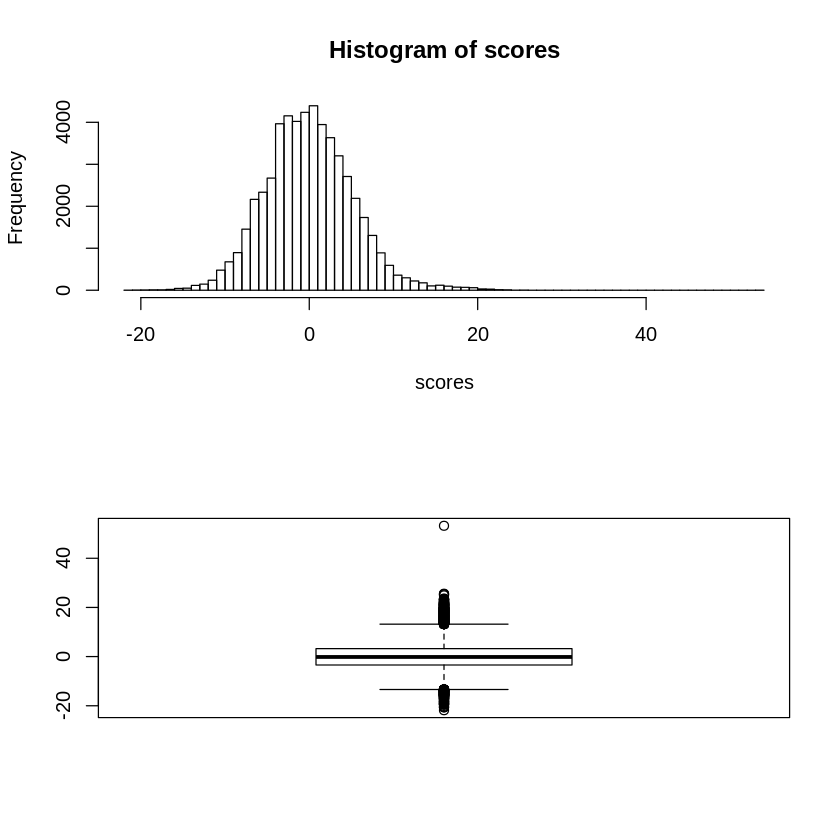

In [13]:
options(scipen=999)
par(mfrow=c(2,1));

#Create histogram of scores
hist(scores,breaks = 100)

#Drawing Boxplot
boxplot(scores,horizontal = FALSE)

Most of the rows have scores in the range of -20 to 20, and the boxplot shows two outliers. 

Check rows with scores > 25.

In [14]:
length(which(scores>25))
diamonds[which(scores>25),]

[1] 4

carat,cut,color,clarity,depth,table,price,x,y,z
2.00,Premium,H,SI2,58.9,57,12210,8.09,58.90,8.06
2.58,Fair,F,SI2,65.2,59,12500,8.58,8.51,5.57
2.00,Fair,F,SI2,70.2,57,15351,7.63,7.59,5.34
0.51,Ideal,E,VS1,61.8,55,2075,5.15,31.80,5.12


Look at the row where the y value  is 31.8. It clearly suggests y value is incorrect. Perhaps some of the digits from the depth value have been incorrectly used for y. 


### Outlier Detection Using Local Outlier Factor (LOF)

Local outlier factor (LOF) is a proximity-based outlier detection model  in Aggarwal's classification scheme.  

The basic procedure is to:

- For each point, compute the density of its local neighborhood.
- Compute local outlier factor (LOF) of a sample p as the average of the ratios of the density of sample p and the density of its nearest neighbors.
- Outliers are points with largest LOF value.

The below wiki page goes into more detail on how this method works. 

**Reference:** 
- [Wiki](https://en.wikipedia.org/wiki/Local_outlier_factor)

#### The LOF algorithm in R

We will demonstrate using the LOF algorithm using the prostate data set and the lofactor method in the Data Mining with R (DMwR) package.

In [15]:
# if(!require(package = 'DMwR')){
#     install.packages('DMwR')
# }
library(DMwR)
print('Done')

Loading required package: lattice
Loading required package: grid


[1] "Done"


In [16]:
#read about the lofactor method
help(lofactor)

In [17]:
# # point to the prostate data set in the h2o folder - no need to load h2o in memory yet

prostate_df <- read.table("/dsa/data/all_datasets/prostate.txt",sep=',',header=TRUE)
head(prostate_df)

ID,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
1,0,65,1,2,1,1.4,0.0,6
2,0,72,1,3,2,6.7,0.0,7
3,0,70,1,1,2,4.9,0.0,6
4,0,76,2,2,1,51.2,20.0,7
5,0,69,1,1,1,12.3,55.9,6
6,1,71,1,3,2,3.3,0.0,8


In [18]:
dim(prostate_df)

[1] 380   9

In [19]:
summary(prostate_df)

       ID            CAPSULE            AGE             RACE      
 Min.   :  1.00   Min.   :0.0000   Min.   :43.00   Min.   :0.000  
 1st Qu.: 95.75   1st Qu.:0.0000   1st Qu.:62.00   1st Qu.:1.000  
 Median :190.50   Median :0.0000   Median :67.00   Median :1.000  
 Mean   :190.50   Mean   :0.4026   Mean   :66.04   Mean   :1.087  
 3rd Qu.:285.25   3rd Qu.:1.0000   3rd Qu.:71.00   3rd Qu.:1.000  
 Max.   :380.00   Max.   :1.0000   Max.   :79.00   Max.   :2.000  
     DPROS           DCAPS            PSA              VOL       
 Min.   :1.000   Min.   :1.000   Min.   :  0.30   Min.   : 0.00  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:  5.00   1st Qu.: 0.00  
 Median :2.000   Median :1.000   Median :  8.75   Median :14.25  
 Mean   :2.271   Mean   :1.108   Mean   : 15.41   Mean   :15.81  
 3rd Qu.:3.000   3rd Qu.:1.000   3rd Qu.: 17.12   3rd Qu.:26.45  
 Max.   :4.000   Max.   :2.000   Max.   :139.70   Max.   :97.60  
    GLEASON     
 Min.   :0.000  
 1st Qu.:6.000  
 Median :6.000  
 

Remove the ID field - we don't need it.

In [20]:
# # We don't need the ID field
prostate_df <- prostate_df[,-1]

We will use `lofactor()` to calculate the local outlier factors. 
In addition to the dataset, we need to specify a value `k`
which is the number of neighbours that will be used in the calculation of the local outlier factors. 

In [21]:
# k=50 indicates use 50 neighbors to determine if a data point is an outlier
outlier.scores <- lofactor(prostate_df, k=50)

In [28]:
head(outlier.scores)

[1] 0.9848503 1.0183062 0.9853142 1.5144195 1.4782006 1.0028343

Now that the outlier scores are calculated, pick the top 10 outliers with highest scores.

In [22]:
outliers <- order(outlier.scores, decreasing=T)[1:10]

# who are outliers
prostate_df[outliers,]

,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
374,1,65,1,4,1,139.7,29.9,9
61,0,59,1,2,1,0.7,96.0,5
303,1,67,1,4,2,135.0,0.0,7
355,0,71,2,2,1,12.3,97.6,5
52,1,72,1,4,2,124.0,38.6,8
234,1,59,2,4,1,126.0,20.3,8
156,0,76,1,2,1,8.9,87.3,5
248,1,57,2,1,1,63.3,73.4,7
104,0,75,1,3,1,25.7,87.6,5
25,1,77,1,1,1,61.1,58.0,7


In [29]:
outliers

[1] 374  61 303 355  52 234 156 248 104  25

#### Visualize Outliers with Plots

Graphical methods are one way to detect outliers.
We can use more than one model in our graphical method by combining our LOF outliers with a biplot of the first two principal components. 
Our LOF-found outliers will be labeled by row number in the biplot of the top two principal components.

In [23]:
?biplot

Standard deviations (1, .., p=8):
[1] 20.0135871 18.3529002  6.4850407  1.0985518  0.8883899  0.4105178  0.3044067
[8]  0.2840765

Rotation (n x k) = (8 x 8):
                PC1          PC2          PC3          PC4           PC5
CAPSULE 0.007924221 -0.003824289  0.001060646 -0.203970786  0.0278663778
AGE     0.004870774  0.042879684 -0.999024899  0.001053685 -0.0088569918
RACE    0.001889059  0.001151964  0.001828310  0.001842896 -0.0215464306
DPROS   0.011465126 -0.004067902  0.005967310 -0.620156292 -0.7750823271
DCAPS   0.004301527 -0.002199623 -0.001525966 -0.072751638 -0.0066813584
PSA     0.996769662 -0.075929904  0.001663056  0.025341495 -0.0044910405
VOL     0.075963101  0.996157872  0.043117095 -0.005604666  0.0003497605
GLEASON 0.020971622 -0.005304523 -0.006708007 -0.753545739  0.6307640002
                 PC6           PC7          PC8
CAPSULE  0.971315468 -0.0794199641 -0.088201878
AGE      0.001414535 -0.0014301619 -0.001804827
RACE    -0.094612068 -0.9806850782 -0.16

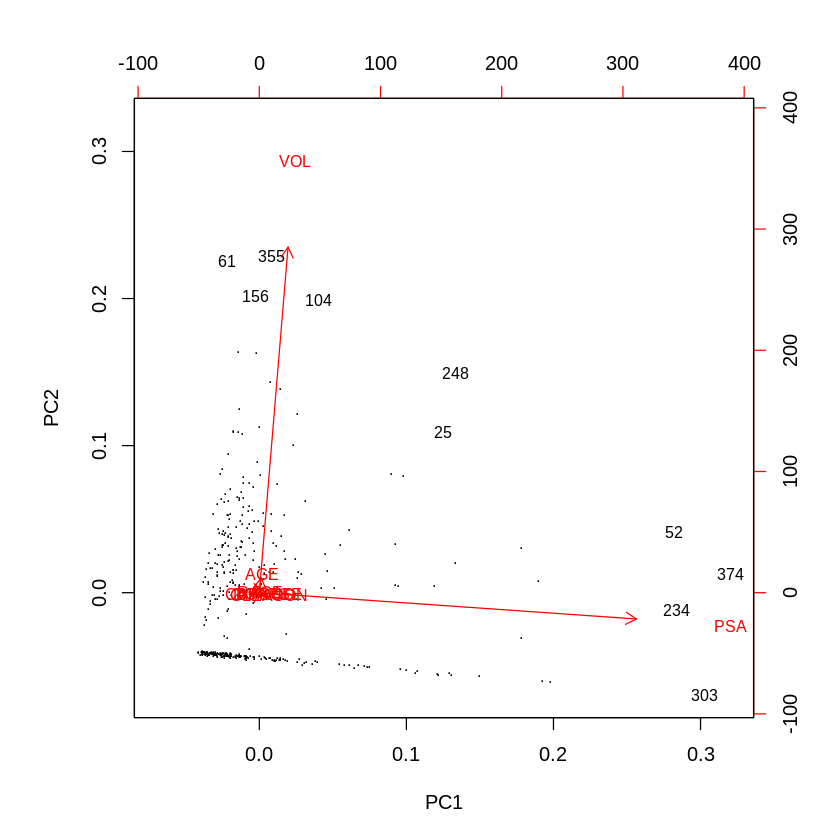

In [24]:
# create labels that are the row numbers for the observations
n <- nrow(prostate_df)
labels <- 1:n

# replace the labels of non-outliers with dots
labels[-outliers] <- "."

prcomp(prostate_df)
#plot the top two principal componenets using biplot
# run help(biplot) for more information
biplot(prcomp(prostate_df), cex=.8, xlabs=labels)

In [30]:
help(biplot)

---